#Load datasets



In [1]:
import albumentations as A
import cv2
from PIL import Image, ImageDraw
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import imageio
import torchvision.transforms.functional as F
import torch.nn.functional as F1

In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import torch
path = '/content/drive/MyDrive/DL/coco.pt'            #coco.pt has 10,000 preprossed image and it's captions for image captioning (from coco dataset)
m =torch.load(path)

In [4]:
print(m)    #m is an dictionary

{'train_images': tensor([[[[ 50,  72,  96,  ..., 188, 173, 129],
          [ 85,  88,  64,  ..., 116, 110,  93],
          [102, 105, 100,  ...,  99, 101,  87],
          ...,
          [151, 136,  89,  ...,  61,  56,  50],
          [146, 133,  90,  ...,  87,  77,  73],
          [148, 130,  88,  ...,  91,  95,  99]],

         [[ 60,  83, 112,  ..., 197, 181, 142],
          [102, 102,  76,  ..., 139, 130, 116],
          [127, 128, 119,  ..., 121, 123, 108],
          ...,
          [140, 124,  71,  ...,  66,  68,  59],
          [135, 121,  69,  ...,  95,  87,  81],
          [145, 123,  68,  ..., 100, 111, 115]],

         [[ 65,  86, 115,  ..., 191, 174, 124],
          [104, 102,  79,  ..., 123, 106,  91],
          [129, 131, 122,  ..., 103, 104,  87],
          ...,
          [118, 102,  50,  ...,  58,  48,  45],
          [112,  99,  52,  ...,  91,  81,  74],
          [126,  95,  48,  ...,  93,  96,  98]]],


        [[[255, 255, 255,  ...,  34,  29,  21],
          [255, 25

In [5]:
m['train_captions'].shape

torch.Size([10000, 17])

In [6]:
m['train_captions'][0]

tensor([  1,  15, 175,  19,   8, 132, 690,   4,  73,  10,  28, 146,   2,   0,
          0,   0,   0])

In [7]:
m['train_images'].shape

torch.Size([10000, 3, 112, 112])

In [8]:
m['vocab'][ 'token_to_idx']  #idx_to_token and  'token_to_idx'

#Start is 1 and end is 2

{'<END>': 2,
 '<NULL>': 0,
 '<START>': 1,
 '<UNK>': 3,
 'a': 4,
 'about': 365,
 'above': 251,
 'across': 296,
 'action': 767,
 'adult': 474,
 'adults': 766,
 'after': 815,
 'against': 271,
 'air': 112,
 'airliner': 863,
 'airplane': 141,
 'airplanes': 862,
 'airport': 244,
 'all': 364,
 'alone': 608,
 'along': 226,
 'among': 765,
 'an': 16,
 'and': 10,
 'animal': 426,
 'animals': 288,
 'another': 222,
 'antique': 706,
 'apple': 516,
 'apples': 539,
 'appliances': 732,
 'are': 19,
 'area': 123,
 'arm': 731,
 'around': 109,
 'as': 160,
 'asian': 764,
 'assortment': 671,
 'at': 20,
 'atop': 705,
 'attached': 473,
 'away': 730,
 'baby': 189,
 'back': 180,
 'background': 162,
 'backpack': 861,
 'bag': 435,
 'bags': 641,
 'ball': 72,
 'banana': 295,
 'bananas': 197,
 'bar': 814,
 'base': 444,
 'baseball': 50,
 'basket': 640,
 'bat': 185,
 'bath': 408,
 'bathroom': 61,
 'bathtub': 538,
 'batter': 318,
 'be': 344,
 'beach': 70,
 'bear': 100,
 'bears': 331,
 'beautiful': 415,
 'bed': 74,
 'bedr

In [9]:
max(m['vocab'][ 'token_to_idx'].values())  #we have 864 words in the dict including stop, start, end etc.

863

In [10]:
m['vocab'][ 'idx_to_token'][5]   #This is the way to excess the word when we have index

'on'

In [11]:
#Function to generate the sentence from the indexes for the given image

def generate_caption(caption):
  cc = caption.clone().cpu()
  sentence = ''
  for i in cc:
    sentence += m['vocab'][ 'idx_to_token'][i] 
    sentence += ' '

  return sentence




In [12]:
generate_caption(m['train_captions'][0])

'<START> two giraffes are in their pen a building and some trees <END> <NULL> <NULL> <NULL> <NULL> '

In [13]:
images = m['train_images']
captions = m['train_captions']

##Visualizing the Final data

In [14]:
#Shapes of images and captions

print("Shapes of final images: ", images.shape)
print("Shapes of final captions: ", captions.shape)

Shapes of final images:  torch.Size([10000, 3, 112, 112])
Shapes of final captions:  torch.Size([10000, 17])


Image: 


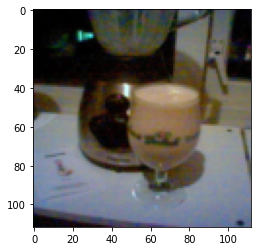

It's captions: 
<START> a table with a blender and a glass on it <END> <NULL> <NULL> <NULL> <NULL> <NULL> 


In [15]:
#Displaying one image with it's captions:
import matplotlib.pyplot as plt 
import numpy as np

idx = 10
print("Image: ")
plt.imshow((images[idx].permute(1,2,0)).numpy())
plt.show()

print("It's captions: ")
print(generate_caption(captions[idx]))

In [16]:
#Converting the images into tensor
if torch.cuda.is_available():
  print("cuda GPU is available")
  DEVICE = 'cuda'
else:
  print("GPU is not available")
  DEVICE = 'cpu'

cuda GPU is available


In [17]:
images = torch.tensor(images.clone(), device= DEVICE)
captions = torch.tensor(captions.clone(), device= DEVICE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


#Building the forward pass

First we will use vanilla RNN for image captioning.

Credits for the photo: Professor [Justin Johnson](https://web.eecs.umich.edu/~justincj/)

##Vanilla RNN
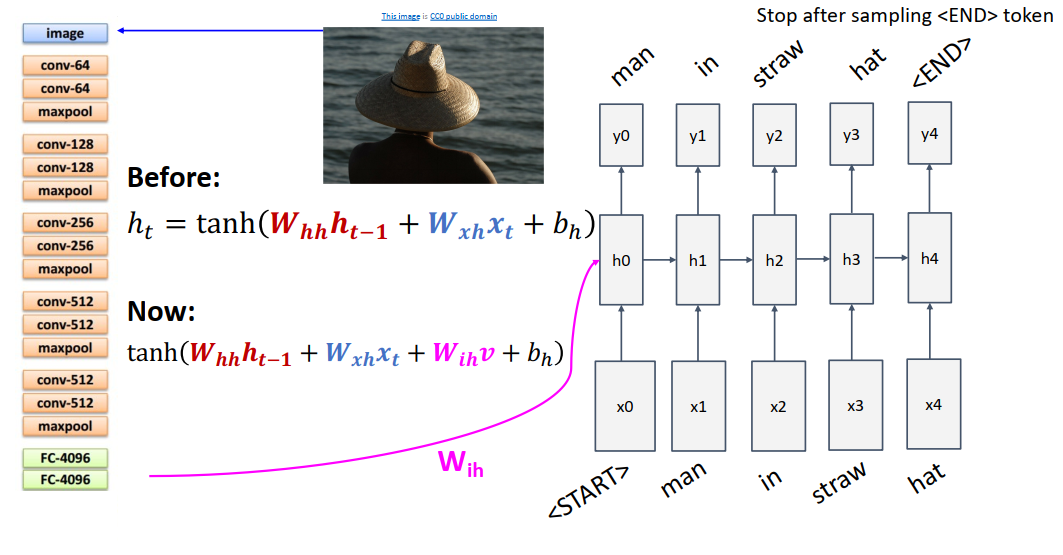

##Feature Extractor
Using VGG-19 as feature extractor

In [18]:
#Using VGG-19 as feature extractor

from torchvision.models.vgg import vgg19
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.detection.backbone_utils import LastLevelMaxPool
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork


# To assist you in designing the feature extractor you may want to print out
# the available nodes for vgg19.
backbone_model = vgg19(pretrained= True).to(DEVICE)
train_nodes, eval_nodes = get_graph_node_names(vgg19())

#Doing requiregrsd =False for pretrained model
for param in backbone_model.parameters():
    param.requires_grad = False

backbone_model.requires_grad_(False)
backbone_model.eval()  

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [19]:
print(train_nodes)
print(eval_nodes)

['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'features.21', 'features.22', 'features.23', 'features.24', 'features.25', 'features.26', 'features.27', 'features.28', 'features.29', 'features.30', 'features.31', 'features.32', 'features.33', 'features.34', 'features.35', 'features.36', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']
['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'fea

In [20]:
return_nodes = {
    # node_name: user-specified key for output dict
    'classifier.4': 'layer1'
}

In [21]:
backbone_feature_extractor = create_feature_extractor(backbone_model, return_nodes=return_nodes).to(DEVICE)

In [22]:
import torchvision
images = images/255.0

#Normalize
norm = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
images = norm(images)   #Don't plot the normalized images directly using matplotlib it will clip he negative values

In [23]:
def feature_extractor(img):  
  with torch.no_grad():
    out = backbone_feature_extractor(img)
    features = out['layer1']
  return features

In [24]:
feature_out = feature_extractor(images[0].reshape(1, images[0].shape[0], images[0].shape[1], images[0].shape[2]))
print("Output from the Feature extractor network (VGG19) for a single image: ", feature_out.shape)

Output from the Feature extractor network (VGG19) for a single image:  torch.Size([1, 4096])


In [25]:
import math

#We can use this to initialize our weights and do forward pass (matrix multiplication)
vocab_size=15
embed_size=10

W_embed = nn.Parameter(
            torch.randn(vocab_size, embed_size).div(math.sqrt(vocab_size)) )
print(W_embed.shape)  #Basically it will make a matrix which will be an learnable weight matrix

torch.Size([15, 10])


In [26]:
#We can also use this to initialize our weights and do forward pass (matrix multiplication)
tryy = nn.Linear(vocab_size, embed_size)
mat = torch.ones(10,15)
tryy(mat).shape

torch.Size([10, 10])

# Making Vanilla RNN architecture

In [41]:
class rnn(nn.Module):

  def __init__(self, time_steps, word_size, embedding_size, feature_size, hidden_size):     #word size is the length of one hot encoded vector which goes as input to embedding layer 
    super(rnn, self).__init__()

    self.word_size = word_size
    self.time_steps = time_steps
    self.hidden_size = hidden_size
    self.embedding = nn.Linear(word_size, embedding_size)    #one hot encoding goes here and produces input for the next hidden layer
    self.wi = nn.Linear(feature_size, hidden_size)           #
    self.wx = nn.Linear(embedding_size, hidden_size)
    self.wh = nn.Linear(hidden_size, hidden_size)

    self.output = nn.Linear(hidden_size, word_size)
    
  def forward(self, x, features):
    hidden = torch.rand((x.shape[1], self.hidden_size), device= DEVICE)
    
    output = torch.zeros((self.time_steps, x.shape[1],self.word_size ), device= DEVICE)

    for i in range(self.time_steps):

      #output = torch.zeros((self.time_steps, x.shape[1],self.word_size ), device= DEVICE)

      #Passing the one hot encoded input x to embedding layer:
      out = self.embedding(x[i])

      #passing the all required outputs to hidden layer and get hidden output h
      hidden = torch.tanh(self.wi(features) + self.wx(out) + self.wh(hidden))

      y = self.output(hidden)

      output[i] = y

    return output


  def step_forward(self,features):

    input = torch.zeros(self.word_size, device= DEVICE)
    input[1] = 1.0

    hidden = torch.ones(self.hidden_size, device= DEVICE)
    

    out_f = []

    for i in range(self.time_steps):

      #Passing the one hot encoded input x to embedding layer:
      out = self.embedding(input)
      
      #passing the all required outputs to hidden layer and get hidden output h
      hidden = torch.tanh(self.wi(features) + self.wx(out) + self.wh(hidden))


      y = self.output(hidden)      
      maxindx = torch.argmax(y)
      y[:] = 0
      y[maxindx] = 1
      input = y
      out_f.append(maxindx.cpu().numpy())

    return torch.tensor(np.array(out_f), device= DEVICE)




   

In [42]:
RNN = rnn(time_steps=17, word_size=864, embedding_size=1000, feature_size=4096, hidden_size=2000).to(device=DEVICE)

In [43]:
ohc = F1.one_hot(captions, num_classes=864)   #  tHIS WILL do the onw hot encoding part for me
print(ohc.shape)
ohcp = ohc.permute(1,0,2)
print(ohcp.shape)

print(ohcp[:,0,:])   #It works. I only have to write the training part now. Everything is almost done

torch.Size([10000, 17, 864])
torch.Size([17, 10000, 864])
tensor([[0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0')


#Training

In [60]:
optimizer = torch.optim.Adam(RNN.parameters(), lr=0.0001)        #update the weights of the RNN
loss_type = torch.nn.CrossEntropyLoss()
step_lr = lr_scheduler.StepLR(optimizer, step_size= 100, gamma = 0.5)  

In [45]:
print(images.shape)
print(captions.shape)
print(ohcp.shape)

torch.Size([10000, 3, 112, 112])
torch.Size([10000, 17])
torch.Size([17, 10000, 864])


In [46]:
ohc = torch.tensor(ohc.detach().cpu().numpy(), device= DEVICE, dtype= torch.float32)

In [47]:
ohc.shape
y_target = torch.zeros_like(captions)
print(y_target.shape)

for i in range(y_target.shape[1]-1):

  y_target[:,i] = captions[:,i+1]

print(y_target.shape)

torch.Size([10000, 17])
torch.Size([10000, 17])


In [61]:
#Model Training
loss_graph = []
num_epochs = 3000
num_train = images.shape[0]
batch_size = 100
RNN.train()
for i in range(num_epochs):
  random_no = torch.randint(0, num_train, (batch_size,))
  imgf = images[random_no]
  x_batch = ohc[random_no]
  y_batch = y_target[random_no]

  x_batch = x_batch.permute(1,0,2)

  feat = feature_extractor(imgf)
  
  optimizer.zero_grad()
  y_pred = RNN.forward(x_batch, feat)
  y_pred = y_pred.permute(1,0,2)
  
 
  y_pred = y_pred.reshape(-1,864)
  y_batch = y_batch.reshape(-1)


  loss = loss_type(y_pred, y_batch )
  loss.backward()
  optimizer.step()
  #step_lr.step()
  loss_graph.append(loss.cpu().item())
  if i%10==0:
    print("Epoch: ", i, ", loss is: ", loss.cpu().item())

Epoch:  0 , loss is:  1.8070182800292969
Epoch:  10 , loss is:  1.7045202255249023
Epoch:  20 , loss is:  1.7676690816879272
Epoch:  30 , loss is:  1.7577170133590698
Epoch:  40 , loss is:  1.67191481590271
Epoch:  50 , loss is:  1.7180030345916748
Epoch:  60 , loss is:  1.8270399570465088
Epoch:  70 , loss is:  1.7101229429244995
Epoch:  80 , loss is:  1.6983802318572998
Epoch:  90 , loss is:  1.7591432332992554
Epoch:  100 , loss is:  1.641783356666565
Epoch:  110 , loss is:  1.6433227062225342
Epoch:  120 , loss is:  1.6417696475982666
Epoch:  130 , loss is:  1.6530342102050781
Epoch:  140 , loss is:  1.7511497735977173
Epoch:  150 , loss is:  1.641814947128296
Epoch:  160 , loss is:  1.531421422958374
Epoch:  170 , loss is:  1.5703277587890625
Epoch:  180 , loss is:  1.6775739192962646
Epoch:  190 , loss is:  1.6070148944854736
Epoch:  200 , loss is:  1.6774802207946777
Epoch:  210 , loss is:  1.6491276025772095
Epoch:  220 , loss is:  1.6530271768569946
Epoch:  230 , loss is:  1.5

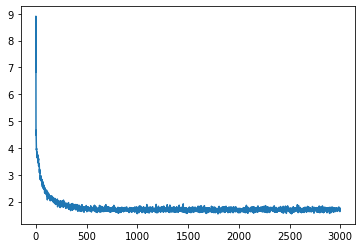

In [49]:
plt.plot(loss_graph)
plt.show()

#Predictions/Inference

In [62]:
idx = 40
RNN.eval()
ff1 = feature_extractor(images[idx].reshape(1, images[idx].shape[0], images[idx].shape[1], images[idx].shape[2]))
ff1 = ff1.reshape(-1)
temp = RNN.step_forward(ff1)
print("Generated captions by our model: ")
generate_caption(temp)

Generated captions by our model: 


'a man riding a white surfboard on a wave in the ocean <END> <NULL> <NULL> <NULL> <NULL> '

In [63]:
print("Actual captions: ")
generate_caption(captions[idx])

Actual captions: 


'<START> a man riding a white surfboard on a wave in the ocean <END> <NULL> <NULL> <NULL> '

#Saving model:

##we can Save and Load the model and use it afterwards whenever we want to use it. It isn't the preferred way to save the model but it can be loaded without defining the weights.

In [64]:
path_save = '/content/drive/MyDrive/DL/model_ng.pth.tar'    #or only .pth
torch.save(RNN, path_save)

In [65]:
load_model = torch.load(path_save)

In [66]:
#Inference by the loaded model:
load_model.eval()
idx = 40
ff1 = feature_extractor(images[idx].reshape(1, images[idx].shape[0], images[idx].shape[1], images[idx].shape[2]))
ff1 = ff1.reshape(-1)
temp = load_model.step_forward(ff1)
print("Generated captions by our model: ")
generate_caption(temp)

Generated captions by our model: 


'a man riding a white surfboard on a wave in the ocean <END> <NULL> <NULL> <NULL> <NULL> '